DATASET DESCRIPTION

The dataset is organized into 3 folders (train, test) and contains subfolders for each image category (Pneumonia/Normal). There are 5,829 X-Ray images (JPEG) and 2 categories (PNEUMONIA/NORMAL). Chest X-ray images were selected from retrospective cohorts of pediatric patients of one to five years old. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [2]:
# imports
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from keras.initializers import Constant
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications import ResNet152V2
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from matplotlib import image
from keras.applications.densenet import DenseNet121

In [4]:
# train, validation, test directories
train_directory = '/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/train/'
val_directory = '/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/val/'
test_directory = '/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/test/'

In [5]:
import os
os.path.exists(train_directory)
os.path.exists(val_directory)
os.path.exists(test_directory)

True

,number_of_images,disease
0,1341,normal
1,3874,pneumonia


<AxesSubplot:xlabel='disease', ylabel='number_of_images'>

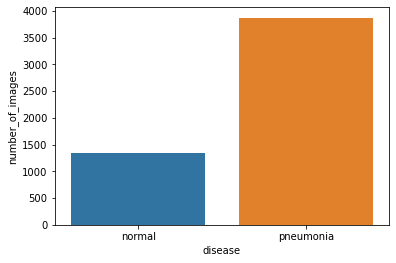

In [6]:
# function calculating number of files in each category : test - normal and pneumonia, train - normal and pneumonia 
def files_calc(path):
    return (len([name for name in os.listdir(path)]))

# calculating number of files in each directory
train_normal_files = files_calc('/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/train/NORMAL')
train_pneumonia_files = files_calc('/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/train/PNEUMONIA')
test_normal_files = files_calc('/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/test/NORMAL')
test_pneumonia_files = files_calc('/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/test//PNEUMONIA')

# dataframe comparing number of train files
train_barplot = pd.DataFrame({'number_of_images':[train_normal_files,train_pneumonia_files], 'disease':['normal', 'pneumonia']})
display(train_barplot)
sns.barplot(y = 'number_of_images', x = 'disease', 
            data = train_barplot)
            


,number_of_images,disease
0,234,normal
1,390,pneumonia


<AxesSubplot:xlabel='disease', ylabel='number_of_images'>

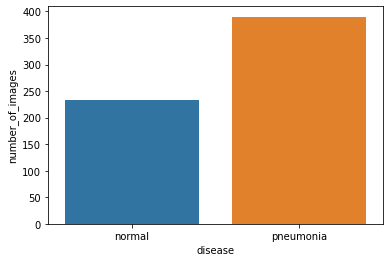

In [7]:
# dataframe comparing number of test files
test_barplot = pd.DataFrame({'number_of_images':[test_normal_files,test_pneumonia_files], 'disease':['normal', 'pneumonia']})
display(test_barplot)

sns.barplot(y = 'number_of_images', x = 'disease', 
            data = test_barplot)
            


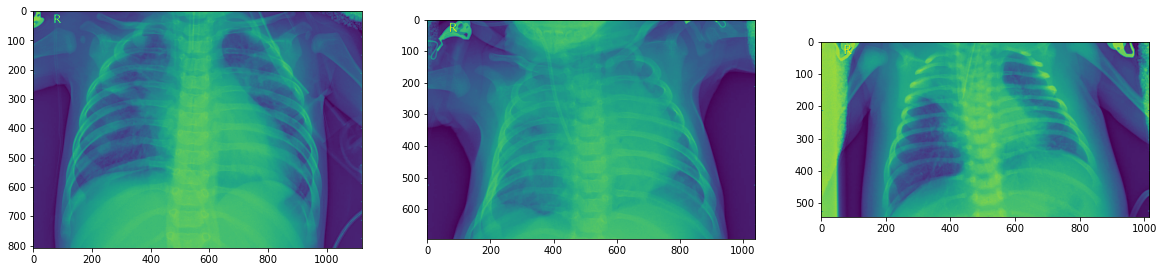

In [8]:
#iterating images in test pneumonia files to show random pictures  
images = [name for name in os.listdir('/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/test//PNEUMONIA')]
plt.figure(figsize=(20,10))
imgages_dir = '/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/test/PNEUMONIA'
for i in range(3):
    plt.subplot(1,3,i+1)
    img = plt.imread(os.path.join(imgages_dir,images[i]))
    plt.imshow(img)  
                     


In [9]:
# Generate batches of tensor image data for training
train_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization= True, # standarization
    # data augmentation
    rotation_range=10, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    rescale=1/255,# rescaling 
    validation_split = 0.05) # 5% split for validation data 

test_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization= True, 
    rescale=1/255)

In [10]:
# setting batch size and input shape 
batchSize=32
h = 160
w = 160

In [11]:
#Load images
train_flow = train_generator.flow_from_directory(
    directory=r'/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/train',
    target_size=(h, w),
    color_mode="rgb",
    batch_size=batchSize,
    class_mode="binary",
    shuffle=True,
    subset = "training",
    seed=10
)

valid_flow = train_generator.flow_from_directory(
    directory=r'/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2/train/',
    target_size=(h, w),
    color_mode="rgb",
    batch_size=batchSize,
    class_mode="binary",
    shuffle=True,
    subset = "validation",
    seed=10
    
)

test_flow = test_generator.flow_from_directory(
    directory=r"/Users/olakopka/Desktop/DATASCIENCE/xray_project/new_data_1/chest_xray-2//test/",
    target_size=(h, w),
    color_mode="rgb",
    batch_size=batchSize,
    class_mode='binary',
    shuffle=False,
    seed=10
    
)




Found 4946 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
# according to https://www.kaggle.com/code/kmkarakaya/transfer-learning-for-image-classification/notebook
stepsPerEpoch= (train_flow.samples+ (batchSize-1)) // batchSize
print("stepsPerEpoch: ", stepsPerEpoch)

validationSteps=(valid_flow.samples+ (batchSize-1)) // batchSize
print("validationSteps: ", validationSteps)


stepsPerEpoch:  155
validationSteps:  9


In [14]:
# because of imbalanced classes according to tensorflow: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias
# I decided to add initial bias to output layer

initial_bias = np.log([train_pneumonia_files/train_normal_files])
initial_bias

array([1.06087196])

In [15]:
# definig functionions to easily assess model 

def treshold(pred):
    if pred <= 0.5:
        return 0
    else:
        return 1

def assess_model(model):
    predicted_vals = model.predict(test_flow, steps = len(test_flow))
    vfunc = np.vectorize(treshold)
    predictions = vfunc(predicted_vals)
    accuracy = accuracy_score(test_flow.classes, predictions) # assessing accuracy_score on test data
    print('Accuracy: %f' % accuracy)
    print()
    f1 = f1_score(test_flow.classes, predictions) # assessing f1_scroe on test data
    print('F1 score: %f' % f1)
    print()
    precision = precision_score(test_flow.classes, predictions) # assessing precision_score on test data
    print('Precision_score : %f' % precision)
    print()
    recall = recall_score(test_flow.classes, predictions) # recall_score on test data
    print('Recall_score: %f' % recall)
    print()
    print('Confusion matrix')
    cm = confusion_matrix(y_true=test_flow.classes, y_pred=predictions)
    print(cm)



In [14]:
# Defining CNN with one Conv2D layer 

In [15]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(8, 3, activation="relu", input_shape=input_shape)) # first layer
    model.add(MaxPool2D((2,2))) # maxpooling over input signal
    model.add(Dropout(0.5)) # adding high dropout to avoid overfitting
    model.add(Flatten())
    model.add(Dense(8, "relu"))
    model.add(Dense(1, "sigmoid",bias_initializer=tf.keras.initializers.Constant(initial_bias))) # adding bias because of data imabalance 
    return model

In [16]:
# builing and compiling model with Adam optimizer 
model = build_model((h, w, 3))
model.compile(loss="binary_crossentropy", 
              optimizer='Adam', 
              metrics=["accuracy"])

2022-05-07 11:38:23.849361: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True) # adding early stopping to avoid overfitting 

history = model.fit(train_flow, 
          validation_data=valid_flow,
          steps_per_epoch=stepsPerEpoch,      
          validation_steps=validationSteps, 
          callbacks = early_stopping,
          epochs = 50)

Epoch 1/50
155/155 [==============================] - 153s 981ms/step - loss: 0.3934 - accuracy: 0.8449 - val_loss: 0.2176 - val_accuracy: 0.9266
Epoch 2/50
155/155 [==============================] - 151s 977ms/step - loss: 0.1992 - accuracy: 0.9167 - val_loss: 0.1800 - val_accuracy: 0.9305
Epoch 3/50
155/155 [==============================] - 150s 962ms/step - loss: 0.1761 - accuracy: 0.9307 - val_loss: 0.1824 - val_accuracy: 0.9189
Epoch 4/50
155/155 [==============================] - 135s 872ms/step - loss: 0.1882 - accuracy: 0.9286 - val_loss: 0.1995 - val_accuracy: 0.9151
Epoch 5/50
155/155 [==============================] - 144s 928ms/step - loss: 0.1672 - accuracy: 0.9367 - val_loss: 0.1529 - val_accuracy: 0.9266
Epoch 6/50
155/155 [==============================] - 151s 976ms/step - loss: 0.1633 - accuracy: 0.9375 - val_loss: 0.2760 - val_accuracy: 0.9073
Epoch 7/50
155/155 [==============================] - 149s 958ms/step - loss: 0.1682 - accuracy: 0.9321 - val_loss: 0.1767 -

In [22]:
assess_model(model)

Accuracy: 0.828526

F1 score: 0.873969

Precision_score : 0.808279

Recall_score: 0.951282

Confusion matrix
[[146  88]
 [ 19 371]]


# Accuracy score on test is 0.828 and val accuracy 0.93 -> overfitting problem 

In [23]:
history_dict = history.history

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)


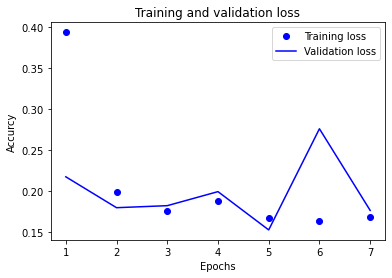

In [26]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accurcy')
plt.legend()
plt.show()

In [27]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

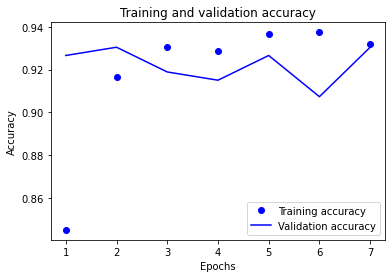

In [28]:
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# As visible above validation accuracy drops while trainig accuracy is increasing on 6 epoch - model starts to overfit

In [ ]:
# defining model with 4 Conv2D layers

In [41]:
def build_model(input_shape):

    model = Sequential()
    model.add(Conv2D(16, 3,activation="relu", padding='valid', input_shape=input_shape)) # first layer with input shape
    model.add(MaxPool2D()) # maxpooling over input signal
    model.add(Dropout(0.2)) # adding dropout to avoid overfitting


    model.add(Conv2D(32, 3,activation="relu", padding='valid')) # second layer
    model.add(MaxPool2D()) # maxpooling over input signal
    model.add(Dropout(0.2))
    
    
    model.add(Conv2D(64, 3,activation="relu", padding='valid'))# third layer
    model.add(Conv2D(64, 3,activation="relu", padding='valid'))# fourth layer
    model.add(MaxPool2D()) # maxpooling over input signal
    model.add(Dropout(0.4)) # adding dropout to avoid overfitting

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) # output layer
    return model

early_stopping = EarlyStopping(monitor='binary_accuracy', patience = 5, restore_best_weights = True)
model = build_model((h,w,3))
model.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(), metrics='binary_accuracy')

In [42]:
history = model.fit(train_flow,
          batch_size=batchSize, epochs=50,
          validation_data=valid_flow,
          steps_per_epoch=stepsPerEpoch,      
          validation_steps=validationSteps, 
          callbacks = early_stopping);

Epoch 1/50
155/155 [==============================] - 230s 1s/step - loss: 0.4474 - binary_accuracy: 0.7782 - val_loss: 0.3924 - val_binary_accuracy: 0.8378
Epoch 2/50
155/155 [==============================] - 227s 1s/step - loss: 0.3491 - binary_accuracy: 0.8653 - val_loss: 0.3227 - val_binary_accuracy: 0.8764
Epoch 3/50
155/155 [==============================] - 171s 1s/step - loss: 0.3042 - binary_accuracy: 0.9005 - val_loss: 0.3007 - val_binary_accuracy: 0.8649
Epoch 4/50
155/155 [==============================] - 171s 1s/step - loss: 0.2953 - binary_accuracy: 0.8999 - val_loss: 0.2557 - val_binary_accuracy: 0.9189
Epoch 5/50
155/155 [==============================] - 167s 1s/step - loss: 0.2572 - binary_accuracy: 0.9228 - val_loss: 0.2454 - val_binary_accuracy: 0.9035
Epoch 6/50
155/155 [==============================] - 167s 1s/step - loss: 0.2541 - binary_accuracy: 0.9207 - val_loss: 0.2205 - val_binary_accuracy: 0.9459
Epoch 7/50
155/155 [==============================] - 166s

In [45]:
assess_model(model)

Accuracy: 0.873397

F1 score: 0.905162

Precision_score : 0.851016

Recall_score: 0.966667

Confusion matrix
[[168  66]
 [ 13 377]]



# Validation accuracy - 0.949, test accuracy - 0.873 -> overfitting problem

In [46]:
history_dict = history.history

In [47]:
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [48]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)


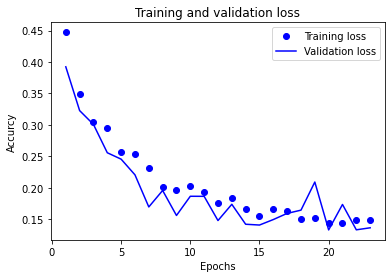

In [49]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accurcy')
plt.legend()
plt.show()

In [51]:
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

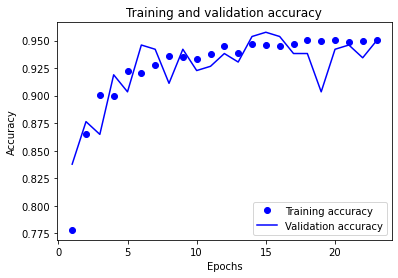

In [52]:
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Validation accuracy drops significantly while trainig accuracy is increasing on 18 epoch - model starts to overfit

In [78]:
# model with SGD optimizer and one Conv2D layer

In [118]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape)) # input Conv2D layer
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    #model.add(Conv2D(8, 3, activation="relu", input_shape=input_shape))
    #model.add(MaxPool2D((2,2)))
    #model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(8, "relu"))
    model.add(Dense(1, "sigmoid"))
    return model

In [119]:
model = build_model((h, w, 3))
model.compile(loss="binary_crossentropy", 
              optimizer='SGD',  # SGD optimizer 
              metrics=["accuracy"])

In [120]:
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True)

history = model.fit(train_flow, 
          validation_data=valid_flow,
          steps_per_epoch=stepsPerEpoch,      
          validation_steps=validationSteps, 
          callbacks = early_stopping_cb,
          epochs = 50)

Epoch 1/50
155/155 [==============================] - 136s 874ms/step - loss: 0.5192 - accuracy: 0.7663 - val_loss: 0.3262 - val_accuracy: 0.8494
Epoch 2/50
155/155 [==============================] - 134s 866ms/step - loss: 0.3246 - accuracy: 0.8623 - val_loss: 0.2642 - val_accuracy: 0.8958
Epoch 3/50
155/155 [==============================] - 135s 869ms/step - loss: 0.2702 - accuracy: 0.8809 - val_loss: 0.3018 - val_accuracy: 0.8456
Epoch 4/50
155/155 [==============================] - 135s 869ms/step - loss: 0.2511 - accuracy: 0.8959 - val_loss: 0.2394 - val_accuracy: 0.8919
Epoch 5/50
155/155 [==============================] - 134s 864ms/step - loss: 0.2270 - accuracy: 0.9102 - val_loss: 0.2052 - val_accuracy: 0.9035
Epoch 6/50
155/155 [==============================] - 134s 865ms/step - loss: 0.2136 - accuracy: 0.9145 - val_loss: 0.1865 - val_accuracy: 0.9112
Epoch 7/50
155/155 [==============================] - 134s 863ms/step - loss: 0.1921 - accuracy: 0.9226 - val_loss: 0.3725 -

In [123]:
assess_model(model)

Accuracy: 0.830128

F1 score: 0.875294

Precision_score : 0.808696

Recall_score: 0.953846

Confusion matrix
[[146  88]
 [ 18 372]]


# Val accuracy - 0.953, test accuracy - 0.83 - > same overfitting effect with both Adam and SGD optimizer

In [124]:
history_dict = history.history

In [125]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)


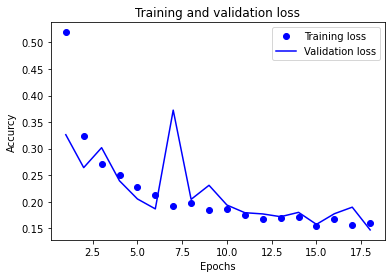

In [127]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accurcy')
plt.legend()
plt.show()

In [128]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

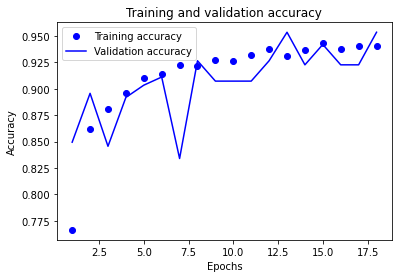

In [129]:
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Validation accuracy drops during 7 epoch  and training accuracy increases

In [ ]:
# Building model with Adam optimizer but with learning rate = 0.002 

In [151]:
def build_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    #model.add(Conv2D(8, 3, activation="relu", input_shape=input_shape))
    #model.add(MaxPool2D((2,2)))
    #model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(8, "relu"))
    model.add(Dense(1, "sigmoid"))
    return model

In [152]:
model = build_model((h, w, 3))
opt=tf.keras.optimizers.Adam(learning_rate=0.002) # changing learning rate of Adam optimizer
model.compile(loss="binary_crossentropy", 
              optimizer=opt, 
              metrics=["accuracy"])

In [167]:
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True)

history = model.fit(train_flow, 
          validation_data=valid_flow,
          steps_per_epoch=stepsPerEpoch,      
          validation_steps=validationSteps, 
          callbacks = early_stopping_cb,
          epochs = 6) # 6 epochs beacause of overfitting problem mentioned above

Epoch 1/6
155/155 [==============================] - 165s 1s/step - loss: 0.1790 - accuracy: 0.9361 - val_loss: 0.2411 - val_accuracy: 0.8919
Epoch 2/6
155/155 [==============================] - 141s 909ms/step - loss: 0.1720 - accuracy: 0.9361 - val_loss: 0.1742 - val_accuracy: 0.9266
Epoch 3/6
155/155 [==============================] - 149s 958ms/step - loss: 0.1537 - accuracy: 0.9464 - val_loss: 0.1792 - val_accuracy: 0.9305
Epoch 4/6
155/155 [==============================] - 182s 1s/step - loss: 0.1633 - accuracy: 0.9397 - val_loss: 0.1826 - val_accuracy: 0.9228
Epoch 5/6
155/155 [==============================] - 184s 1s/step - loss: 0.1575 - accuracy: 0.9444 - val_loss: 0.1856 - val_accuracy: 0.9344
Epoch 6/6
155/155 [==============================] - 203s 1s/step - loss: 0.1599 - accuracy: 0.9440 - val_loss: 0.1684 - val_accuracy: 0.9382


In [170]:
assess_model(model)

Accuracy: 0.862179

F1 score: 0.896635

Precision_score : 0.843891

Recall_score: 0.956410

Confusion matrix
[[165  69]
 [ 17 373]]


In [171]:
history_dict = history.history

In [172]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [173]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)


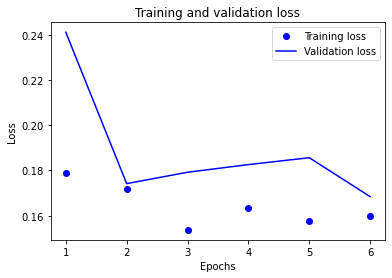

In [174]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [175]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

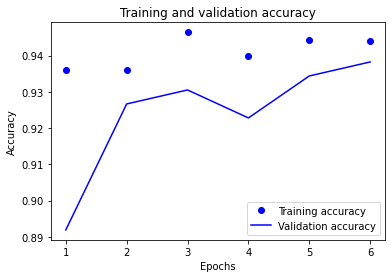

In [176]:
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# validation accuracy - 0.93, test accuracy - 0.86

# TRANSFER LEARNING

Densnet model description: https://docs.openvino.ai/latest/omz_models_model_densenet_121.html

In [27]:

base_model = DenseNet121(weights='imagenet', input_shape= (h, w, 3), include_top=False)

base_model.trainable = False

inputs = tf.keras.Input(shape= (h, w, 3))
x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', 
                             bias_initializer=tf.keras.initializers.Constant(initial_bias)
)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.Recall())

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 5, 5, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_______________________________________________

In [190]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True)

history = model.fit(train_flow, 
          validation_data=valid_flow,
          steps_per_epoch=stepsPerEpoch,      
          validation_steps=validationSteps, 
          callbacks = early_stopping_cb,
          epochs = 50)

Epoch 1/50
155/155 [==============================] - 386s 2s/step - loss: 0.2581 - recall_1: 0.9364 - val_loss: 0.1525 - val_recall_1: 0.9845
Epoch 2/50
155/155 [==============================] - 412s 3s/step - loss: 0.2207 - recall_1: 0.9459 - val_loss: 0.1224 - val_recall_1: 0.9689
Epoch 3/50
155/155 [==============================] - 425s 3s/step - loss: 0.1845 - recall_1: 0.9563 - val_loss: 0.1215 - val_recall_1: 0.9689
Epoch 4/50
155/155 [==============================] - 347s 2s/step - loss: 0.1741 - recall_1: 0.9579 - val_loss: 0.1123 - val_recall_1: 0.9585
Epoch 5/50
155/155 [==============================] - 336s 2s/step - loss: 0.1899 - recall_1: 0.9525 - val_loss: 0.1037 - val_recall_1: 0.9793
Epoch 6/50
155/155 [==============================] - 337s 2s/step - loss: 0.1806 - recall_1: 0.9568 - val_loss: 0.1077 - val_recall_1: 0.9741
Epoch 7/50
155/155 [==============================] - 340s 2s/step - loss: 0.1690 - recall_1: 0.9622 - val_loss: 0.1169 - val_recall_1: 0.9637

In [191]:
assess_model(model)

Accuracy: 0.854167

F1 score: 0.892308

Precision_score : 0.828571

Recall_score: 0.966667

Confusion matrix
[[156  78]
 [ 13 377]]


In [192]:
history_dict = history.history

In [193]:
history_dict.keys()

dict_keys(['loss', 'recall_1', 'val_loss', 'val_recall_1'])

In [195]:
acc = history.history['recall_1']
val_acc = history.history['val_recall_1']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)


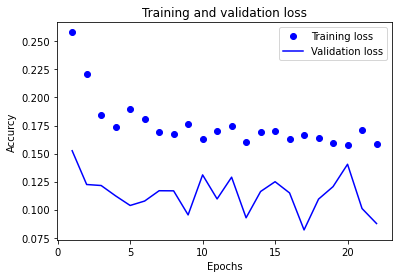

In [196]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accurcy')
plt.legend()
plt.show()

In [198]:
acc_values = history_dict['recall_1']
val_acc_values = history_dict['val_recall_1']

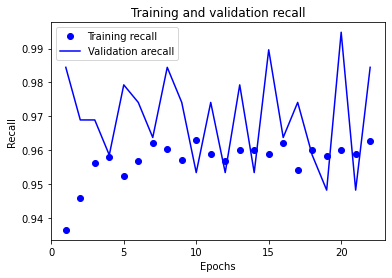

In [199]:
plt.plot(epochs, acc_values, 'bo', label='Training recall')
plt.plot(epochs, val_acc_values, 'b', label='Validation arecall')

plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

ResNet152V2 model description: https://docs.w3cub.com/tensorflow~2.3/keras/applications/resnet152v2

In [29]:

base_model = ResNet152V2(weights='imagenet', input_shape= (h, w, 3), include_top=False)


base_model.trainable = False

inputs = tf.keras.Input(shape= (h, w, 3))

x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', 
                             bias_initializer=tf.keras.initializers.Constant(initial_bias)
)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.Recall())

In [30]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 5, 5, 2048)        58331648  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 58,333,697
Trainable params: 2,049
Non-trainable params: 58,331,648
_________________________________________________________________


In [204]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True)

history = model.fit(train_flow, 
          validation_data=valid_flow,
          steps_per_epoch=stepsPerEpoch,      
          validation_steps=validationSteps, 
          callbacks = early_stopping_cb,
          epochs = 50)

Epoch 1/50
155/155 [==============================] - 832s 5s/step - loss: 0.3034 - recall_2: 0.9408 - val_loss: 0.2508 - val_recall_2: 0.9326
Epoch 2/50
155/155 [==============================] - 737s 5s/step - loss: 0.2095 - recall_2: 0.9590 - val_loss: 0.2135 - val_recall_2: 0.9430
Epoch 3/50
155/155 [==============================] - 876s 6s/step - loss: 0.1974 - recall_2: 0.9584 - val_loss: 0.1993 - val_recall_2: 0.9378
Epoch 4/50
155/155 [==============================] - 881s 6s/step - loss: 0.1803 - recall_2: 0.9617 - val_loss: 0.1867 - val_recall_2: 0.9482
Epoch 5/50
155/155 [==============================] - 813s 5s/step - loss: 0.1675 - recall_2: 0.9617 - val_loss: 0.1725 - val_recall_2: 0.9896
Epoch 6/50
155/155 [==============================] - 662s 4s/step - loss: 0.1568 - recall_2: 0.9671 - val_loss: 0.1673 - val_recall_2: 0.9793
Epoch 7/50
155/155 [==============================] - 680s 4s/step - loss: 0.1628 - recall_2: 0.9620 - val_loss: 0.2302 - val_recall_2: 0.9896

In [205]:
assess_model(model)

Accuracy: 0.847756

F1 score: 0.885680

Precision_score : 0.834467

Recall_score: 0.943590

Confusion matrix
[[161  73]
 [ 22 368]]


In [206]:
history_dict = history.history

In [207]:
history_dict.keys()

dict_keys(['loss', 'recall_2', 'val_loss', 'val_recall_2'])

In [209]:
acc = history.history['recall_2']
val_acc = history.history['val_recall_2']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)


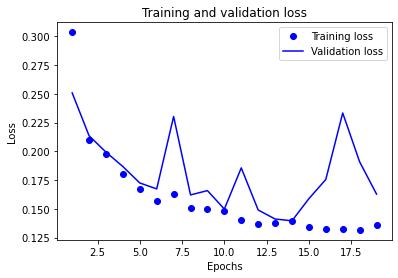

In [210]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [213]:
acc_values = history_dict['recall_2']
val_acc_values = history_dict['val_recall_2']

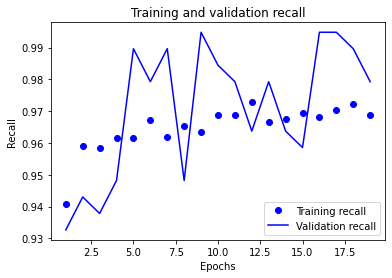

In [215]:
plt.plot(epochs, acc_values, 'bo', label='Training recall')
plt.plot(epochs, val_acc_values, 'b', label='Validation recall')

plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Accuracy score on test with Densenet121 and ResNet152V2 models is 0.84% 